In [ ]:
!pip install pykan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.3/77.3 kB 3.7 MB/s eta 0:00:00


In [ ]:
import torch
from kan import *
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import joblib
import numpy as np

In [ ]:
# Load your datasets
datasets = joblib.load('/content/drive/MyDrive/Research/Regression Analysis - Qult and SF/Modeling - SF/Pickles/datasets.pkl')

# Access individual datasets
X_train = datasets['X_train']
X_test = datasets['X_test']
y_train = datasets['y_train']
y_test = datasets['y_test']

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32, device=device)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32, device=device)
# Convert y_train and y_test to NumPy arrays before converting to tensors
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32, device=device).reshape(-1, 1)
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.float32, device=device).reshape(-1, 1)

# Prepare the dataset in the required format
dataset = {
    'train_input': X_train_tensor,
    'test_input': X_test_tensor,
    'train_label': y_train_tensor,
    'test_label': y_test_tensor
}

print("Train data shape: {}".format(dataset['train_input'].shape))
print("Train target shape: {}".format(dataset['train_label'].shape))
print("Test data shape: {}".format(dataset['test_input'].shape))
print("Test target shape: {}".format(dataset['test_label'].shape))
print("====================================")

Train data shape: torch.Size([3072, 5])
Train target shape: torch.Size([3072, 1])
Test data shape: torch.Size([768, 5])
Test target shape: torch.Size([768, 1])


In [ ]:
# Define the RMSE calculation
def rmse(predictions, targets):
    return torch.sqrt(torch.nn.functional.mse_loss(predictions, targets))

# Define the R-squared calculation
def r2_score(predictions, targets):
    ss_res = torch.sum((targets - predictions) ** 2)
    ss_tot = torch.sum((targets - torch.mean(targets)) ** 2)
    return 1 - (ss_res / ss_tot)

# Define lists to store RMSE values during training
train_rmse_values = []
test_rmse_values = []

# Define the RMSE calculation
def train_rmse():
    with torch.no_grad():
        predictions = model(dataset['train_input'])
        rmse = torch.sqrt(torch.nn.functional.mse_loss(predictions, dataset['train_label']))
        train_rmse_values.append(rmse.item())
    return rmse

def test_rmse():
    with torch.no_grad():
        predictions = model(dataset['test_input'])
        rmse = torch.sqrt(torch.nn.functional.mse_loss(predictions, dataset['test_label']))
        test_rmse_values.append(rmse.item())
    return rmse

# Define the R-squared calculation
def train_r2():
    with torch.no_grad():
        predictions = model(dataset['train_input'])
        r2 = r2_score(predictions, dataset['train_label'])
    return r2

def test_r2():
    with torch.no_grad():
        predictions = model(dataset['test_input'])
        r2 = r2_score(predictions, dataset['test_label'])
    return r2

In [ ]:
# Define the KAN model
# Adjust the `width` parameter to match the number of input features in your dataset
model = KAN(width=[X_train.shape[1], 200, 1], grid=15, k=3, seed=0, device=device)

# Fit the model
results = model.fit(dataset,
                    opt="LBFGS",
                    metrics=(train_rmse, test_rmse, train_r2, test_r2),
                    loss_fn=torch.nn.MSELoss(),
                    steps=25,
                    lamb=0.001,
                    lamb_entropy=2.,
                    save_fig=False)

# Get and print the final RMSE and R-squared scores for train and test sets
final_train_rmse = train_rmse().item()
final_test_rmse = test_rmse().item()
final_train_r2 = train_r2().item()
final_test_r2 = test_r2().item()

# Print the metrics
print(f"Final Train RMSE: {final_train_rmse:.4f}")
print(f"Final Test RMSE: {final_test_rmse:.4f}")
print(f"Final Train R-squared: {final_train_r2:.4f}")
print(f"Final Test R-squared: {final_test_r2:.4f}")

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.65e-02 | test_loss: 4.93e-02 | reg: 3.26e+01 | : 100%|█| 25/25 [00:34<00:00,  1.39s/


saving model version 0.1
Final Train RMSE: 0.0365
Final Test RMSE: 0.0493
Final Train R-squared: 0.9983
Final Test R-squared: 0.9965


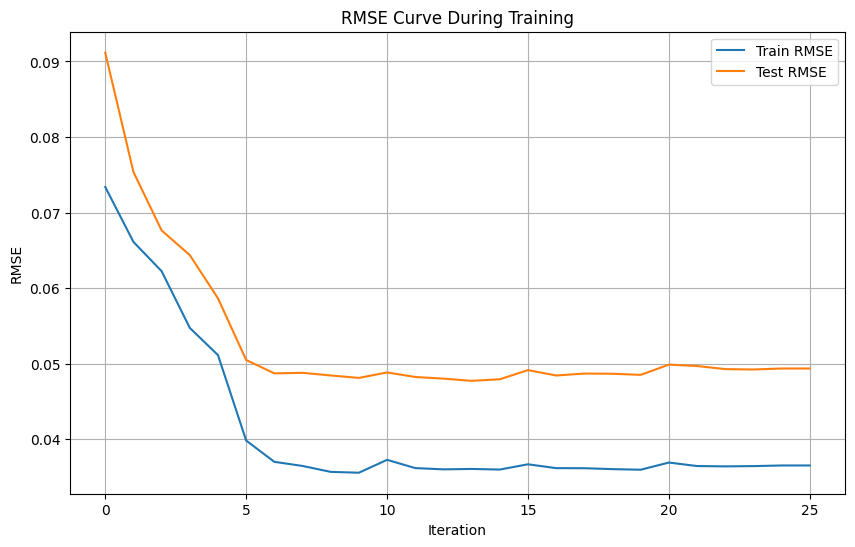

In [ ]:
# Plot the RMSE curve
plt.figure(figsize=(10, 6))
plt.plot(train_rmse_values, label='Train RMSE')
plt.plot(test_rmse_values, label='Test RMSE')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('RMSE Curve During Training')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Save the model using torch
torch.save(model.state_dict(), '/content/drive/MyDrive/Research/Regression Analysis - Qult and SF/Modeling - SF/Pickles/kans_model.pth')

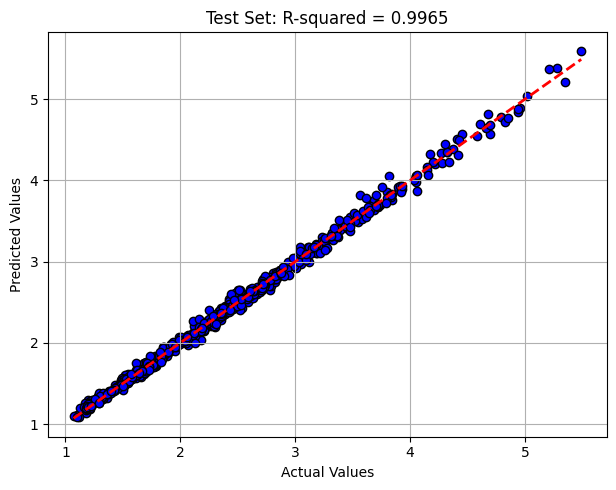

In [ ]:
import matplotlib.pyplot as plt

# Get predictions for train and test sets
with torch.no_grad():
    train_predictions = model(dataset['train_input']).cpu().numpy()
    test_predictions = model(dataset['test_input']).cpu().numpy()
    train_targets = dataset['train_label'].cpu().numpy()
    test_targets = dataset['test_label'].cpu().numpy()

# Create scatter plots for train and test sets
plt.figure(figsize=(12, 5))

# Scatter plot for test set
plt.subplot(1, 2, 2)
plt.scatter(test_targets, test_predictions, alpha=1, color='blue', edgecolors='k')
plt.plot([test_targets.min(), test_targets.max()], [test_targets.min(), test_targets.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Test Set: R-squared = {final_test_r2:.4f}')
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()

In [ ]:
# To load the model later:
model = KAN(width=[X_train.shape[1], 100, 1], grid=15, k=3, seed=0, device=device)
model.load_state_dict(torch.load('/content/drive/MyDrive/Research/Regression Analysis - Qult and SF/Modeling - SF/Pickles/kans_model.pth'))